# Data Gathering

In [ ]:
# Mencoba terhubung dengan penyimpanan google drive
from google.colab import drive
drive.mount('/content/drive')

# Mengimport beberapa library yang dibutuhkan
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Mounted at /content/drive


In [ ]:
# Membaca sumber file
data = pd.read_excel('/content/drive/MyDrive/Potfolio/sms+spam+collection/spam collection.xlsx')
data

,message,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will ü b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


# Data Preparation & Preprocessing

In [ ]:
# Membersihkan data dari nilai-nilai non-teks
data['message'] = data['message'].apply(lambda x: str(x).lower() if isinstance(x, str) else '')

# Mengganti nilai ham dan spam menjadi label
data['label'] = LabelEncoder().fit_transform(data['label'])

# Melakukan splitting data dan membaginya kedalam data train dan test
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.1, random_state=42)

print("Jumlah data training x:", len(X_train))
print("Jumlah data training y:", len(y_train))
print("Jumlah data testing x:", len(X_test))
print("Jumlah data testing y:", len(y_test))

Jumlah data training x: 5014
Jumlah data training y: 5014
Jumlah data testing x: 558
Jumlah data testing y: 558


In [ ]:
# Membuat variabel untuk pesan
sentences = X_train
testing_sentences = X_test

# Melakukan tokenizing ke kalimat per kata
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)

# Menggabungkan kata hasil tokenizing menjadi kalimat tokenize
sequences = tokenizer.texts_to_sequences(sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# Melakukan padding untuk setiap kalimat
padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=10)
testing_padded = pad_sequences(testing_sequences, maxlen=10)

# Melihat index untuk setiap kata
word_index = tokenizer.word_index

print(word_index, "\n")
print(sequences, "\n")
print(testing_sequences, "\n")
print(padded, "\n")
print(testing_padded, "\n")

{'<OOV>': 1, 'i': 2, 'to': 3, 'you': 4, 'a': 5, 'the': 6, 'u': 7, 'and': 8, 'in': 9, 'is': 10, 'me': 11, 'my': 12, 'for': 13, 'your': 14, 'it': 15, 'of': 16, 'call': 17, 'have': 18, 'on': 19, '2': 20, 'that': 21, 'are': 22, 'now': 23, 'so': 24, 'but': 25, 'not': 26, 'or': 27, 'do': 28, 'can': 29, "i'm": 30, 'at': 31, 'get': 32, 'will': 33, 'be': 34, 'ur': 35, 'if': 36, 'with': 37, 'just': 38, 'no': 39, 'we': 40, 'this': 41, '4': 42, 'gt': 43, 'lt': 44, 'up': 45, 'when': 46, 'ok': 47, 'how': 48, 'free': 49, 'go': 50, 'from': 51, 'what': 52, 'all': 53, 'out': 54, 'know': 55, 'good': 56, 'got': 57, 'like': 58, 'was': 59, 'come': 60, 'then': 61, 'am': 62, 'time': 63, 'its': 64, 'only': 65, 'love': 66, 'day': 67, 'there': 68, 'send': 69, 'he': 70, 'text': 71, 'want': 72, 'as': 73, 'by': 74, 'home': 75, 'txt': 76, 'one': 77, 'need': 78, 'going': 79, 'ü': 80, 'sorry': 81, 'about': 82, "i'll": 83, 'still': 84, 'stop': 85, 'see': 86, 'reply': 87, 'n': 88, 'lor': 89, 'da': 90, 'dont': 91, 'r': 9

# Modelling

In [ ]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Buat model wrapper untuk Keras
def build_model(embedding_dim=16, lstm_units=64, dense_units=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=1000, output_dim=embedding_dim, input_length=10),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

# Wrap model dalam KerasClassifier
model = KerasClassifier(dense_units=16, embedding_dim=16, lstm_units=32,
                        model=build_model, verbose=0)

# Hyperparameter yang ingin dijelajahi
param_grid = {
    'embedding_dim': [16, 32, 64],
    'lstm_units': [32, 64, 128],
    'dense_units': [32, 64, 128],
    'epochs': [3]  # Jumlah epoch yang ingin dijelajahi
}

# Inisialisasi Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# Jalankan pencarian hyperparameter
grid_search_result = grid_search.fit(padded, y_train)

# Pencarian hasil terbaik
print("Best Parameters: ", grid_search_result.best_params_)


Best Parameters:  {'dense_units': 32, 'embedding_dim': 64, 'epochs': 3, 'lstm_units': 64}


In [ ]:
# Menyusun infrastruktur model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=1000, output_dim=16, input_length=10),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Melakukan compiling
model.compile(
    loss= 'binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Rangkuman model
model.summary()

# Melatih model
history = model.fit(
    padded,  # Data train
    y_train,  # Label train
    epochs=3,  # Jumlah epoch yang sesuai dengan kebutuhan Anda
    validation_data=(testing_padded, y_test)  # Data test dan label test
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 16)            16000     
                                                                 
 bidirectional (Bidirection  (None, 10, 128)           41472     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 100801 (393.75 KB)
Trainable params: 10080

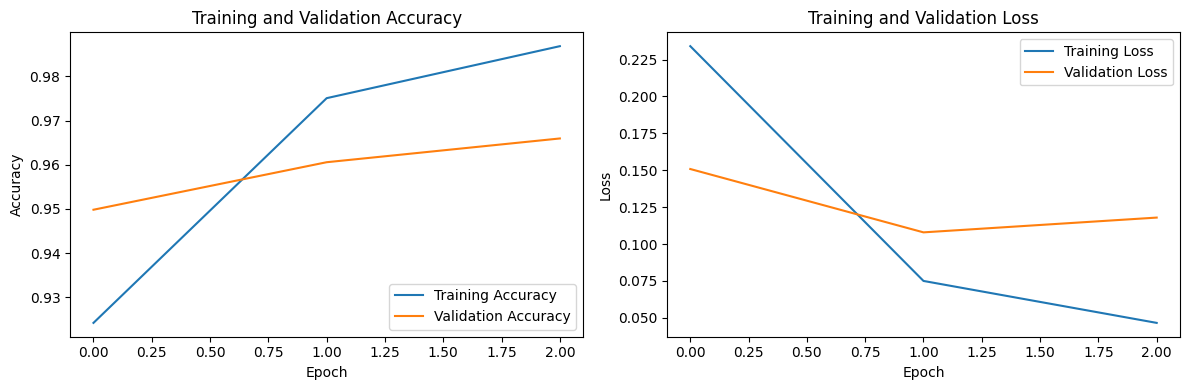

18/18 [==============================] - 0s 5ms/step - loss: 0.1179 - accuracy: 0.9659
Loss: 0.1179
Accuracy: 96.59%


In [ ]:
# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Evaluasi model pada data test
loss, accuracy = model.evaluate(testing_padded, y_test)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

In [ ]:
model.save("Spam detector model")

# Let's try to predict some sentences

In [ ]:
def predict(input_text):
# Fungsi ini bekerja untuk meprediksi apakah suatu teks merupakan spam atau ham dengan cara memasukan kalimat untuk diuji

  # Tokenisasi dan padding data input
  input_sequences = tokenizer.texts_to_sequences(input_text)
  input_padded = pad_sequences(input_sequences, padding='post', truncating='post', maxlen=10)  # Sesuaikan dengan maxlen yang Anda gunakan selama pelatihan

  # Melakukan prediksi
  predictions = model.predict(input_padded)

  predicted_labels = (predictions > 0.5).astype(int)

  # Hasil prediksi
  print("Probabilitas Prediksi:", predictions)
  print("Label Prediksi:", predicted_labels)

In [ ]:
# Jalankan code ini untuk melakukan simulasi!
input_text = [input("Masukan teks dalam bahasa inggris:")]
predict(input_text)

Masukan teks dalam bahasa inggris:Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
1/1 [==============================] - 0s 20ms/step
Probabilitas Prediksi: [[0.99980754]]
Label Prediksi: [[1]]
